In [1]:
import pandas as pd
import datetime
import requests
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import pickle

timeWindow = 2000
coinTo = "BTC"
ccFrom = "EUR"
exchange = "Kraken"
a=[]

def getHistPriceData(coinTo, ccFrom, limit, exchange):
    curl = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&e={}'\
            .format(coinTo.upper(), ccFrom.upper(), limit, exchange)
    data = requests.get(curl, headers={'User-Agent': 'Mozilla/5.0'}).json()['Data']
    df = pd.DataFrame(data)
    df['date'] = [datetime.datetime.fromtimestamp(d).strftime('%Y-%m-%d') for d in df.time]
    return df
df=getHistPriceData(coinTo, ccFrom,timeWindow, exchange)
print(df)
df.to_csv('BITCU.csv')
df.shape

            time    close     high      low     open  volumefrom     volumeto  \
0     1429833600   213.00   217.00   211.05   215.43     2208.77    470943.96   
1     1429920000   207.87   213.97   207.13   213.00     1362.56    285681.29   
2     1430006400   203.27   208.45   198.79   207.87     2808.99    567474.50   
3     1430092800   209.50   215.28   201.67   203.27     3006.31    620851.79   
4     1430179200   206.60   211.34   203.92   209.50     2434.85    504065.87   
...          ...      ...      ...      ...      ...         ...          ...   
1996  1602288000  9520.20  9687.30  9346.80  9347.80     3055.63  29233165.54   
1997  1602374400  9631.40  9650.00  9508.50  9520.20     2276.86  21856893.40   
1998  1602460800  9744.70  9920.00  9500.00  9631.40     5208.09  50505175.81   
1999  1602547200  9736.50  9810.10  9645.00  9744.70     4023.62  39156778.43   
2000  1602633600  9655.50  9830.00  9654.90  9736.50     2633.15  25647272.07   

            date  
0     20

(2001, 8)

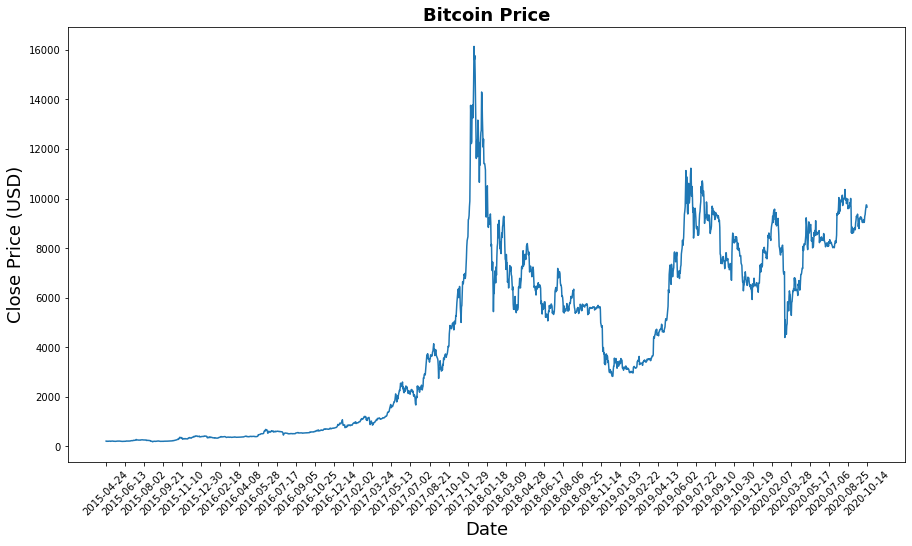

In [4]:
price = df[['close']]

plt.figure(figsize = (15,8))
plt.plot(price)
plt.xticks(range(0, df.shape[0],50), df['date'].loc[::50],rotation=45)
plt.title("Bitcoin Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()
df['date'] = pd.to_datetime(df['date'])

In [6]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2001 non-null   float64
dtypes: float64(1)
memory usage: 15.8 KB


In [21]:
min_max_scaler = MinMaxScaler()

norm_data = min_max_scaler.fit_transform(price.values)

In [22]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [28]:
past_history = 100
future_target = 0

TRAIN_SPLIT = int(len(norm_data) * 0.8)


x_train, y_train = univariate_data(norm_data,0,TRAIN_SPLIT,past_history,future_target)

x_test, y_test = univariate_data(norm_data,TRAIN_SPLIT,None,past_history,future_target)

In [45]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout

num_units = 56
learning_rate = 0.005
activation_function = 'sigmoid'
adam = Adam(lr=learning_rate)
loss_function = 'mse'
batch_size = 5
num_epochs = 50

# Initialize the RNN
model = Sequential()
model.add(LSTM(units = num_units, activation=activation_function, input_shape=(None, 1)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.1))
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer=adam, loss=loss_function)

In [46]:
history = model.fit(x_train, y_train, validation_split=0.1, batch_size=batch_size, epochs=num_epochs, shuffle=False)

Epoch 1/50
270/270 [==============================] - 4s 15ms/step - loss: 0.0141 - val_loss: 0.0732
Epoch 2/50
270/270 [==============================] - 4s 16ms/step - loss: 0.0104 - val_loss: 0.0725
Epoch 3/50
270/270 [==============================] - 4s 15ms/step - loss: 0.0107 - val_loss: 0.0885
Epoch 4/50
270/270 [==============================] - 4s 15ms/step - loss: 0.0102 - val_loss: 0.0973
Epoch 5/50
270/270 [==============================] - 4s 15ms/step - loss: 0.0102 - val_loss: 0.1009
Epoch 6/50
270/270 [==============================] - 4s 15ms/step - loss: 0.0111 - val_loss: 0.1013
Epoch 7/50
270/270 [==============================] - 4s 15ms/step - loss: 0.0101 - val_loss: 0.1048
Epoch 8/50
270/270 [==============================] - 4s 15ms/step - loss: 0.0102 - val_loss: 0.1036
Epoch 9/50
270/270 [==============================] - 4s 15ms/step - loss: 0.0101 - val_loss: 0.1039
Epoch 10/50
270/270 [==============================] - 4s 15ms/step - loss: 0.0099 - val_lo

### To compare training loss to validation loss

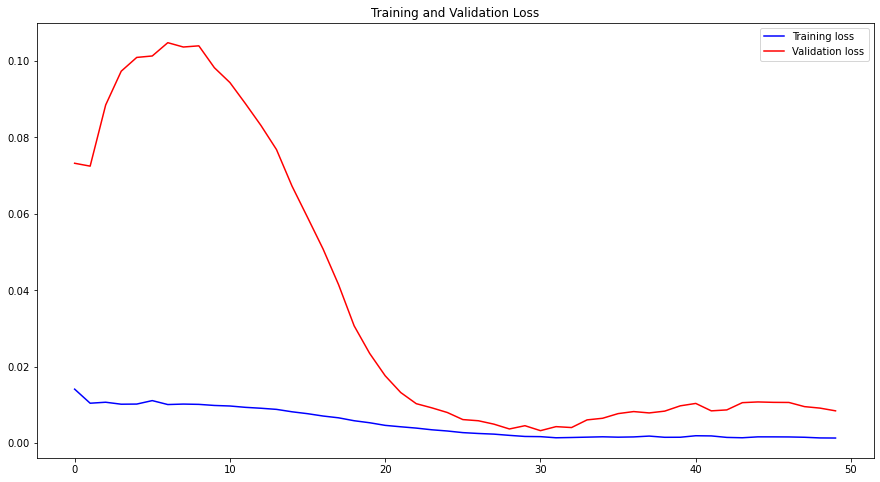

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(15,8))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

[]

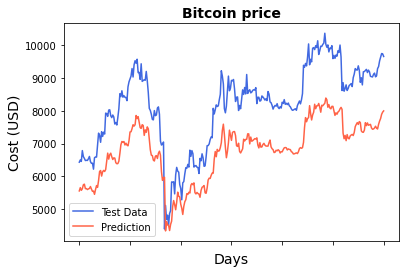

In [48]:
import seaborn as sns
original = pd.DataFrame(min_max_scaler.inverse_transform(y_test))
predictions = pd.DataFrame(min_max_scaler.inverse_transform(model.predict(x_test)))

ax = sns.lineplot(x=original.index, y=original[0], label="Test Data", color='royalblue')
ax = sns.lineplot(x=predictions.index, y=predictions[0], label="Prediction", color='tomato')
ax.set_title('Bitcoin price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)